In [2]:
import os
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
%matplotlib inline

from keras import backend as K
K.set_image_data_format('channels_first')

from keras.models import model_from_json

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [3]:
nFace = 450

In [4]:
import tensorflow as tf

import keras.backend.tensorflow_backend as tfback
def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

In [5]:
tfback._get_available_gpus = _get_available_gpus
tfback._get_available_gpus()

[]

In [6]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]

In [7]:
from keras.models import model_from_json
FNmodel = model_from_json(open(r'C:\Users\abdalah\Face Recognition\FaceNet\FaceNet_Model\FaceNet.json').read())
FNmodel.load_weights(r'C:\Users\abdalah\Face Recognition\FaceNet\FaceNet_Model\FaceNet_weights.h5')

In [8]:
nFeature = FNmodel.output.get_shape().as_list()[1]

In [9]:
def one_hot(Y):
    C = len(list(set(Y)))
    Y_OH = np.eye(C)[Y.reshape(-1)]

    return Y_OH

In [10]:
def evaluate_model(model, X_train, Y_train, X_test, Y_test, maxItem = 100):
    #test model on training data set and testing data set
    nTrain = min([maxItem, X_train.shape[0]])
    print('Performance on Training data set (%d)' % nTrain)
    preds = model.evaluate(X_train[0:nTrain], Y_train[0:nTrain])
    print ("Loss = " + str(preds[0]))
    print ("Train Accuracy = " + str(preds[1]))

    nTest = min([maxItem, X_test.shape[0]])
    print('Performance on Testing data set (%d)' % nTest)
    preds = model.evaluate(X_test[0:nTest], Y_test[0:nTest])
    print ("Loss = " + str(preds[0]))
    print ("Test Accuracy = " + str(preds[1]))

In [11]:
def load_FaceData(datapath =r'C:\\Users\\abdalah\\Face Recognition\\FaceNet\\Caltech\\Processed\\'):
    FaceData = []
    for iFace in range(nFace):
        im = misc.imread(datapath+'cf%04d.png' % iFace)
        im = misc.imresize(im,(96,96,3))
        im = np.around(np.transpose(im, (2,0,1))/255.0, decimals=12)
        #im = np.transpose(im,[2,0,1])
        FaceData.append(im)
    FaceData = np.array(FaceData)
    labels = np.load(datapath+'Labels.npy')
    labels_OH = one_hot(labels)
    return FaceData, labels,labels_OH

In [90]:
print(FaceData)

[array([[[0.72941176, 0.34509804, 0.08235294, ..., 0.3254902 ,
         0.27843137, 0.2627451 ],
        [0.74901961, 0.36470588, 0.10196078, ..., 0.38431373,
         0.3372549 , 0.3254902 ],
        [0.73333333, 0.34901961, 0.07843137, ..., 0.4745098 ,
         0.41960784, 0.38823529]],

       [[0.75686275, 0.73333333, 0.41960784, ..., 0.35686275,
         0.36862745, 0.24313725],
        [0.77647059, 0.76078431, 0.44705882, ..., 0.41568627,
         0.42745098, 0.31372549],
        [0.76078431, 0.73333333, 0.41568627, ..., 0.49803922,
         0.50196078, 0.36862745]],

       [[0.67058824, 0.74509804, 0.74509804, ..., 0.27843137,
         0.34901961, 0.21176471],
        [0.69803922, 0.77254902, 0.77254902, ..., 0.3372549 ,
         0.41568627, 0.28627451],
        [0.67058824, 0.74509804, 0.74117647, ..., 0.41176471,
         0.47843137, 0.34117647]],

       ...,

       [[0.67058824, 0.66666667, 0.66666667, ..., 0.21960784,
         0.21960784, 0.20392157],
        [0.65882353,

In [12]:
Mypath = r'C:\\Users\\abdalah\\Face Recognition\\FaceNet\\Caltech\\Processed\\'
FaceData, labels, labels_OH = load_FaceData(Mypath)
print(FaceData.shape)
print(labels.shape)
print(labels_OH.shape)

C:\Users\abdalah\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
C:\Users\abdalah\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


(450, 3, 96, 96)
(450,)
(450, 31)


In [13]:
FaceEmbedding = FNmodel.predict(FaceData)

In [14]:
pca = decomposition.PCA(n_components = 2)

In [15]:
x_std = StandardScaler().fit_transform(FaceEmbedding)
x_feature_pca = pca.fit_transform(x_std)

In [17]:
def face_dist(f1,f2,w=1):
    if w==1:
        w = np.ones(f1.shape)
    if len(f1.shape)==len(f2.shape)==1:
        dist = np.linalg.norm((f1-f2)*w)
    else:
        dist = np.linalg.norm((f1-f2)*w, axis=1)
    return dist

In [18]:

Distances_within_class = []
Distances_among_class = []

FaceEmbedding_Dist = np.ones((nFace,nFace))*100
for i in range(nFace):
    for j in range(i,nFace):
        FaceEmbedding_Dist[i,j]=face_dist(FaceEmbedding[i,:],FaceEmbedding[j,:])
        FaceEmbedding_Dist[j,i]=FaceEmbedding_Dist[i,j]
        if labels[i]==labels[j]:
            Distances_within_class.append(FaceEmbedding_Dist[i,j])
        else:
            Distances_among_class.append(FaceEmbedding_Dist[i,j])
            
Distances_within_class = np.array(Distances_within_class)
Distances_among_class = np.array(Distances_among_class)

C:\Users\abdalah\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
C:\Users\abdalah\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Cross-class distance = 0.805 +\- 0.168
Same-class distance = 0.519 +\- 0.232


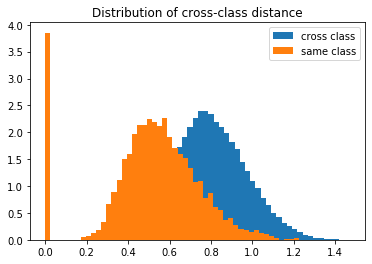

In [19]:

plt.figure()
_ = plt.hist(Distances_among_class,bins = 50, label = 'cross class',normed = True)
_ = plt.hist(Distances_within_class,bins = 50, label = 'same class', normed = True)
plt.title('Distribution of cross-class distance')
plt.legend()

print('Cross-class distance = %1.3f +\- %1.3f' % (Distances_among_class.mean(), Distances_among_class.std()))
print('Same-class distance = %1.3f +\- %1.3f' % (Distances_within_class.mean(), Distances_within_class.std()))

pct of false positive 23.812 %
pct of false negative 22.103 %
accuracy = 76.268


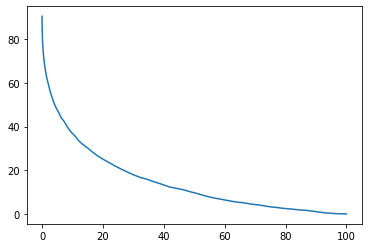

In [20]:
FP = []
FN = []

for threshold in np.arange(0,max(Distances_among_class),0.01):
    FP.append(100.0*np.sum(Distances_among_class<threshold)/len(Distances_among_class))
    FN.append(100.0*np.sum(Distances_within_class>threshold)/len(Distances_within_class))
    
plt.plot(FP,FN)  
threshold = 0.68
print('pct of false positive %2.3f %%' % (100.0*np.sum(Distances_among_class<threshold)/len(Distances_among_class)))
print('pct of false negative %2.3f %%' % (100.0*np.sum(Distances_within_class>threshold)/len(Distances_within_class)))

print('accuracy = %2.3f' % (100.0*(np.sum(Distances_among_class>threshold)+np.sum(Distances_within_class<threshold))/(len(Distances_among_class)+len(Distances_within_class))))

In [21]:

train_idx = []
test_idx = []
for l in set(labels):
    ind = np.where(labels==l)[0]
    if len(ind)<=1:
        ind_train = list(ind)
        ind_test = []
    else:
        i_split = max([3,int(len(ind)*0.7)])
        ind_train = list(ind[0:i_split])
        ind_test = list(ind[i_split:])
    train_idx += ind_train
    test_idx += ind_test  
print("Training data set has %d face images", len(train_idx))
print("Test data set has %d face images", len(test_idx))

Training data set has %d face images 307
Test data set has %d face images 143


In [23]:

nPeople = len(list(set(labels)))
X_input = Input((nFeature,))
X = Dense(128,activation = 'relu')(X_input)
X = Dropout(0.5, seed = 1)(X)
X = Dense(nPeople,activation = 'softmax')(X)
myModel = Model(inputs = X_input, outputs = X, name='FaceRecoModel')
myModel.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
myModel.summary()

Model: "FaceRecoModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 31)                3999      
Total params: 20,511
Trainable params: 20,511
Non-trainable params: 0
_________________________________________________________________


In [24]:

def distance_based_prediction(FaceEmbedding, Labels, f):
    
    Dists = face_dist(FaceEmbedding,f)
    
    i = np.argmin(Dists)
    
    return Labels[i]

In [25]:
nCorrect = 0
for i in test_idx:
    p = distance_based_prediction(FaceEmbedding[train_idx], labels[train_idx], FaceEmbedding[i])
    if p == labels[i]:
        nCorrect += 1
print('Face recognition accuracy using purely distance based method: %3.3f %%' % (100.*(0.+nCorrect)/len(test_idx)))

Face recognition accuracy using purely distance based method: 74.126 %


In [26]:
evaluate_model(myModel, FaceEmbedding[train_idx], labels_OH[train_idx], FaceEmbedding[test_idx], labels_OH[test_idx], maxItem = 1000)

Performance on Training data set (307)
307/307 [==============================] - 0s 829us/step
Loss = 3.437281568974548
Train Accuracy = 0.04234527796506882
Performance on Testing data set (143)
143/143 [==============================] - 0s 112us/step
Loss = 3.4332485649135562
Test Accuracy = 0.0279720276594162


In [27]:
myModel.fit(FaceEmbedding[train_idx], labels_OH[train_idx], epochs = 300, batch_size = 32)

Epoch 1/300
307/307 [==============================] - 0s 2ms/step - loss: 3.4056 - accuracy: 0.0521
Epoch 2/300
307/307 [==============================] - 0s 156us/step - loss: 3.3285 - accuracy: 0.1107
Epoch 3/300
307/307 [==============================] - 0s 157us/step - loss: 3.2677 - accuracy: 0.1205
Epoch 4/300
307/307 [==============================] - 0s 130us/step - loss: 3.1921 - accuracy: 0.1694
Epoch 5/300
307/307 [==============================] - 0s 143us/step - loss: 3.1291 - accuracy: 0.1824
Epoch 6/300
307/307 [==============================] - 0s 117us/step - loss: 3.0382 - accuracy: 0.2280
Epoch 7/300
307/307 [==============================] - 0s 156us/step - loss: 2.9725 - accuracy: 0.2443
Epoch 8/300
307/307 [==============================] - 0s 143us/step - loss: 2.9126 - accuracy: 0.2313
Epoch 9/300
307/307 [==============================] - 0s 130us/step - loss: 2.8426 - accuracy: 0.3029
Epoch 10/300
307/307 [==============================] - 0s 130us/step - los

307/307 [==============================] - 0s 91us/step - loss: 0.8358 - accuracy: 0.7622
Epoch 80/300
307/307 [==============================] - 0s 104us/step - loss: 0.8095 - accuracy: 0.7948
Epoch 81/300
307/307 [==============================] - 0s 117us/step - loss: 0.8190 - accuracy: 0.7752
Epoch 82/300
307/307 [==============================] - 0s 104us/step - loss: 0.7857 - accuracy: 0.7850
Epoch 83/300
307/307 [==============================] - 0s 104us/step - loss: 0.8201 - accuracy: 0.7622
Epoch 84/300
307/307 [==============================] - 0s 91us/step - loss: 0.7876 - accuracy: 0.7915
Epoch 85/300
307/307 [==============================] - 0s 104us/step - loss: 0.7514 - accuracy: 0.8143
Epoch 86/300
307/307 [==============================] - 0s 104us/step - loss: 0.7352 - accuracy: 0.8306
Epoch 87/300
307/307 [==============================] - 0s 104us/step - loss: 0.7432 - accuracy: 0.8176
Epoch 88/300
307/307 [==============================] - 0s 91us/step - loss: 0.

307/307 [==============================] - 0s 104us/step - loss: 0.4387 - accuracy: 0.8990
Epoch 158/300
307/307 [==============================] - 0s 91us/step - loss: 0.3954 - accuracy: 0.9055
Epoch 159/300
307/307 [==============================] - ETA: 0s - loss: 0.5466 - accuracy: 0.75 - 0s 143us/step - loss: 0.3775 - accuracy: 0.9055
Epoch 160/300
307/307 [==============================] - 0s 98us/step - loss: 0.4143 - accuracy: 0.8925
Epoch 161/300
307/307 [==============================] - 0s 91us/step - loss: 0.3959 - accuracy: 0.9121
Epoch 162/300
307/307 [==============================] - 0s 91us/step - loss: 0.4042 - accuracy: 0.8893
Epoch 163/300
307/307 [==============================] - 0s 108us/step - loss: 0.3689 - accuracy: 0.9121
Epoch 164/300
307/307 [==============================] - 0s 104us/step - loss: 0.3785 - accuracy: 0.9088
Epoch 165/300
307/307 [==============================] - 0s 104us/step - loss: 0.3505 - accuracy: 0.9088
Epoch 166/300
307/307 [========

307/307 [==============================] - 0s 104us/step - loss: 0.2281 - accuracy: 0.9544
Epoch 235/300
307/307 [==============================] - 0s 104us/step - loss: 0.2302 - accuracy: 0.9577
Epoch 236/300
307/307 [==============================] - 0s 104us/step - loss: 0.2237 - accuracy: 0.9642
Epoch 237/300
307/307 [==============================] - 0s 104us/step - loss: 0.2241 - accuracy: 0.9642
Epoch 238/300
307/307 [==============================] - 0s 91us/step - loss: 0.2343 - accuracy: 0.9381
Epoch 239/300
307/307 [==============================] - 0s 104us/step - loss: 0.2609 - accuracy: 0.9283
Epoch 240/300
307/307 [==============================] - 0s 104us/step - loss: 0.2363 - accuracy: 0.9414
Epoch 241/300
307/307 [==============================] - 0s 91us/step - loss: 0.2437 - accuracy: 0.9349
Epoch 242/300
307/307 [==============================] - 0s 78us/step - loss: 0.2546 - accuracy: 0.9349
Epoch 243/300
307/307 [==============================] - 0s 117us/step -

In [28]:
evaluate_model(myModel, FaceEmbedding[train_idx], labels_OH[train_idx], FaceEmbedding[test_idx], labels_OH[test_idx], maxItem = 1000)

Performance on Training data set (307)
307/307 [==============================] - 0s 52us/step
Loss = 0.055346979999289836
Train Accuracy = 0.9967426657676697
Performance on Testing data set (143)
143/143 [==============================] - 0s 56us/step
Loss = 0.5543848515807331
Test Accuracy = 0.867132842540741


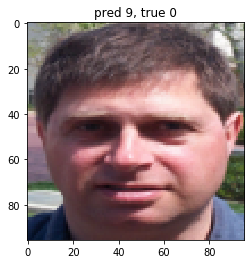

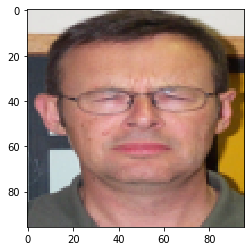

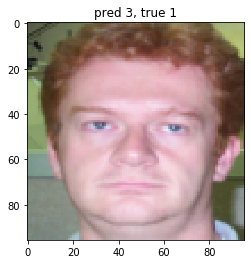

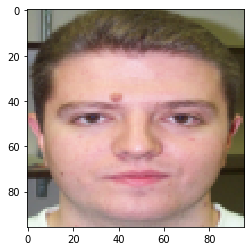

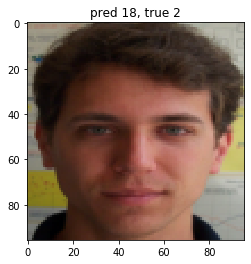

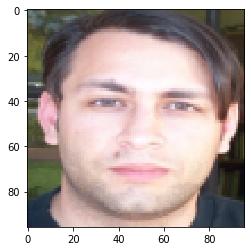

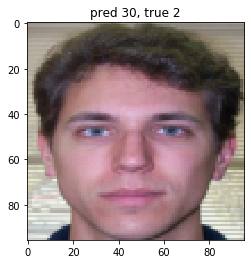

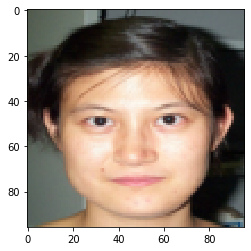

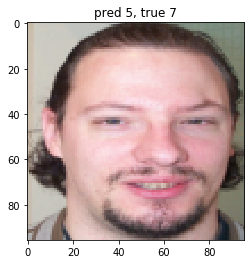

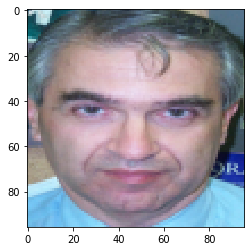

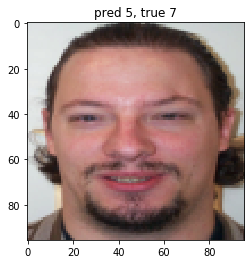

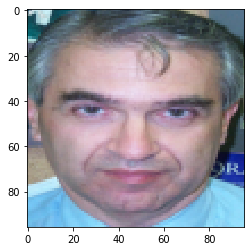

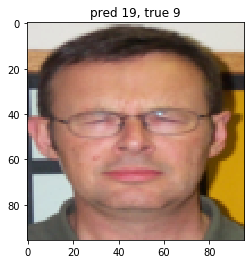

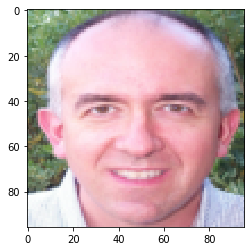

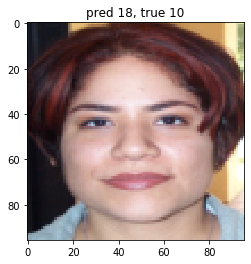

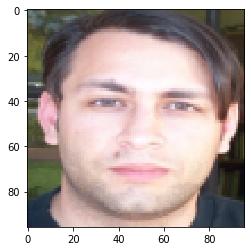

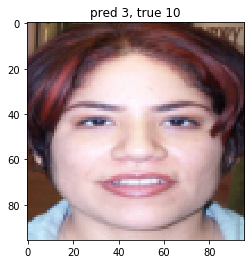

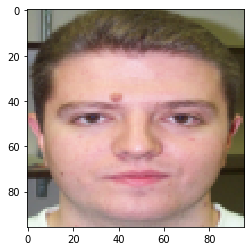

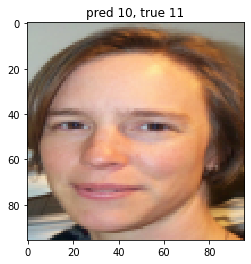

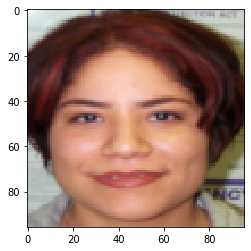

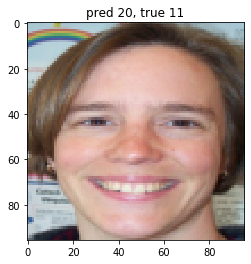

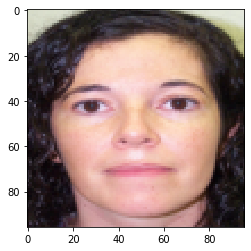

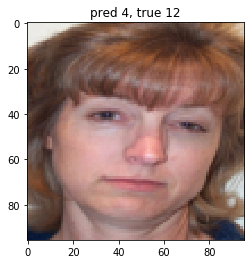

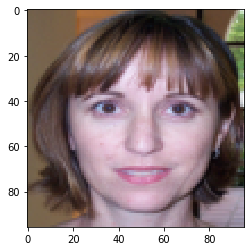

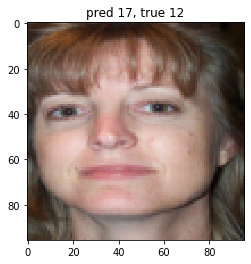

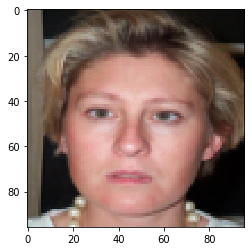

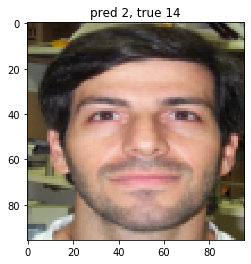

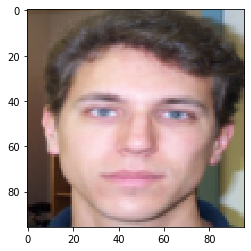

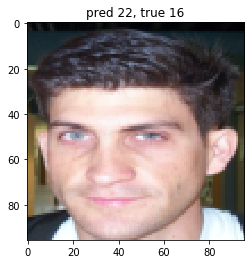

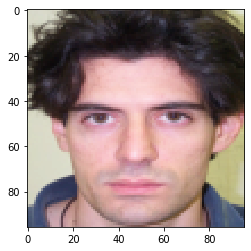

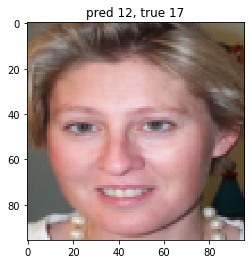

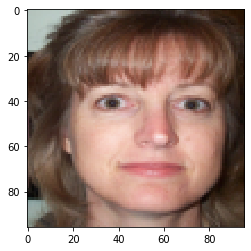

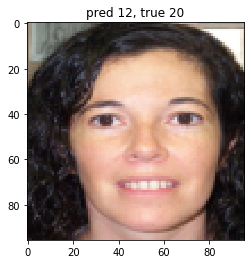

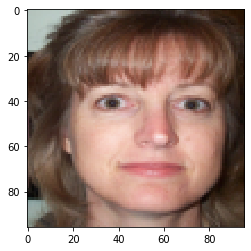

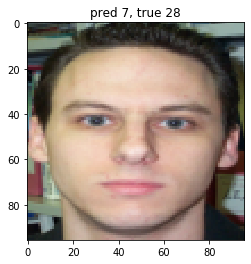

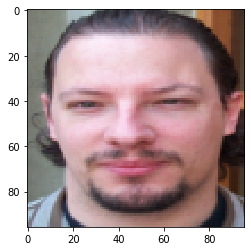

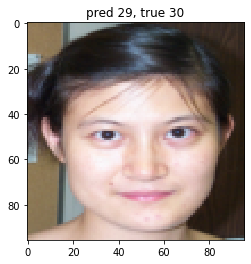

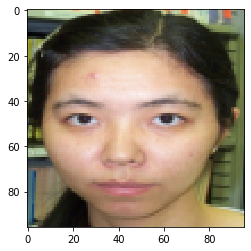

In [29]:
for j in test_idx:
    p=np.argmax(myModel.predict(FaceEmbedding[j:j+1,:]))
    if p!=labels[j]:
        plt.figure()
        plt.imshow(FaceData[j].transpose((1,2,0)))
        plt.title('pred %d, true %d' % (p,labels[j]))
        plt.show()
        plt.figure()
        tmp = np.where(labels==p)[0][0]
        plt.imshow(FaceData[tmp].transpose((1,2,0)))
        plt.show()

In [30]:
FaceEmbedding.shape

(450, 128)